In [1]:
import tensorflow as tf
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
image_size =64
def preproccessing(file_path):
  image=tf.io.read_file(file_path)
  image=tf.image.decode_jpeg(image)
  image = tf.cast(image,tf.float32)
  image = tf.image.resize(image, (image_size,image_size))
  image = image/255.0
  image = tf.reshape(image,shape = (image_size,image_size,3))
  return image


In [3]:
batch_size =  128

In [4]:
output_folder = "archive\img_align_celeba\cropped"

In [5]:
images = [os.path.join(output_folder, image) for image in os.listdir(output_folder) ]
images[:2]

['archive\\img_align_celeba\\cropped\\000001.jpg',
 'archive\\img_align_celeba\\cropped\\000002.jpg']

In [6]:
images = images[:50000]
training_dataset = tf.data.Dataset.from_tensor_slices((images))
training_dataset = training_dataset.map(preproccessing)
training_dataset = training_dataset.shuffle(1000).batch(batch_size)


In [7]:
len(training_dataset)

391

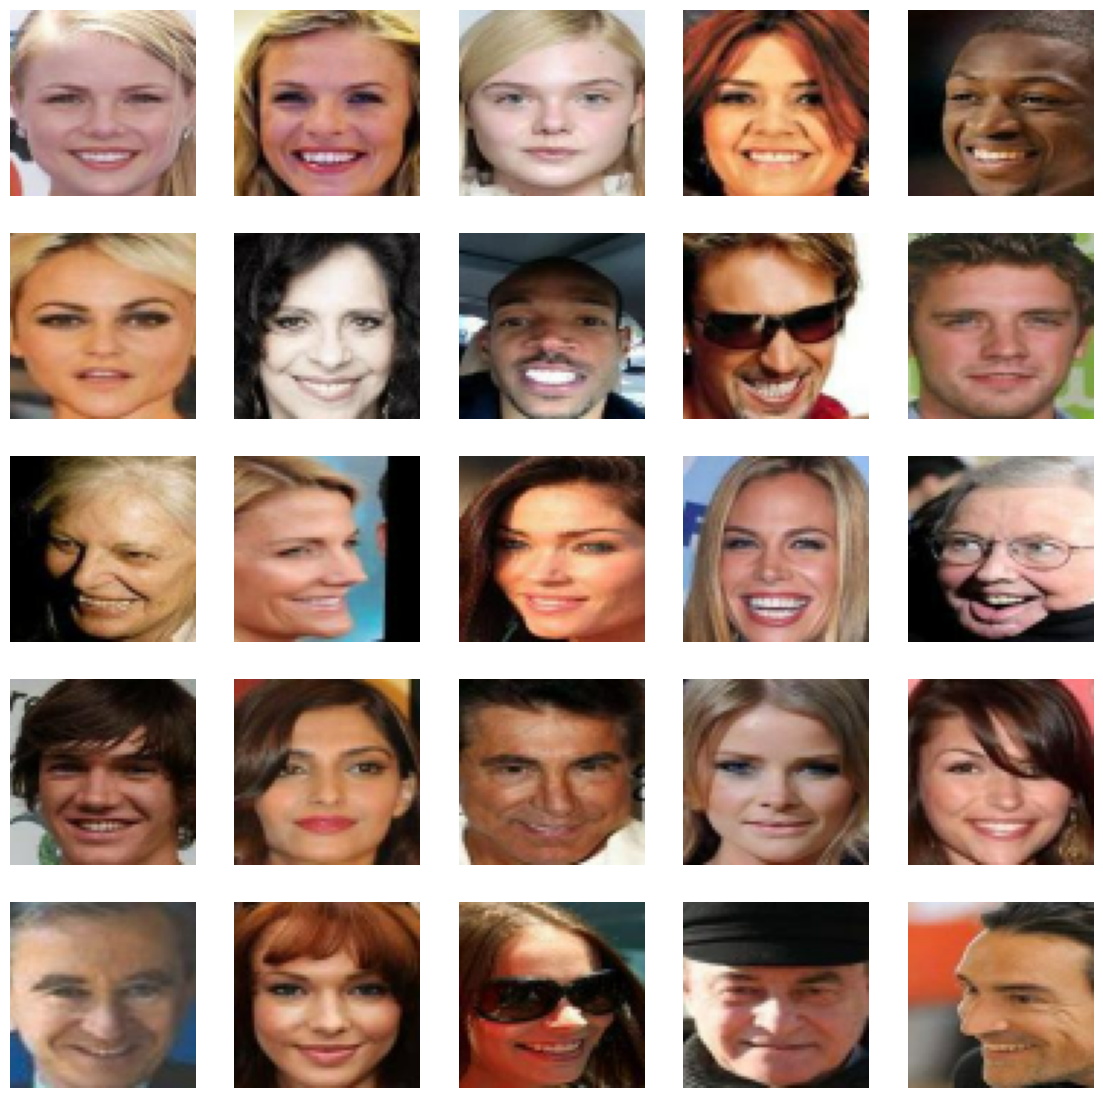

In [8]:
fig,axes = plt.subplots(5,5,figsize =(14,14))
sample = training_dataset.unbatch().take(25)
sample =[image for image in sample]
for i in range(5):
  for j in range(5):
    axes[i,j].imshow(sample[5*i+j])
    axes[i,j].axis('off')
plt.show()

In [9]:
latent_dim = 128

In [10]:
from keras.models import Sequential, Model

from keras.layers import Dense, Conv2D, Conv2DTranspose, Input, Flatten, BatchNormalization, Lambda, Reshape, Activation
from keras.layers import LeakyReLU
from keras.activations import selu
from keras.layers import Multiply, Add
from keras.optimizers import Adam

import tensorflow.keras.backend as K


In [11]:
# encoder
encoder_input  = Input(shape = (image_size,image_size,3))
x = Conv2D(32 ,kernel_size =5,activation = LeakyReLU(0.02), strides = 1, padding = 'same')(encoder_input)
x = BatchNormalization()(x)
filters =[64,128,256,512]
for filter in filters:
  x = Conv2D(filter,kernel_size = 5, activation = LeakyReLU(0.02), strides = 2, padding = 'same')(x)
  x= BatchNormalization()(x)

x = Flatten()(x)
x = Dense(1024, activation = selu)(x)
encoder_output = BatchNormalization()(x)
# samling 
def sampling(args):
    mu, log_var = args
    epsilon = tf.random.normal(shape=tf.shape(mu))
    return mu + tf.exp(0.5 * log_var) * epsilon

from tensorflow.keras.layers import Layer
import tensorflow as tf

class Sampling(Layer):
    def call(self, inputs):
        mu, log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(mu))
        z = mu + tf.exp(0.5 * log_var) * epsilon
        kl = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var))
        self.add_loss(kl)
        return z

mu = Dense(latent_dim)(encoder_output)
log_var = Dense(latent_dim)(encoder_output)
# epsilon = tf.random.normal(shape=(tf.shape(mu)[0],tf.shape(mu)[1]))
# sigma = tf.exp(0.5 * log_var)

# z_eps = Multiply()([sigma, epsilon])
z = Sampling()([mu, log_var])


encoder = Model(encoder_input, outputs = [mu, log_var, z], name = 'encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      2,432 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     51,264 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │    204,928 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 256) │    819,456 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 256) │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 4, 4, 512) │  3,277,312 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 512) │      2,048 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8192)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │  8,389,632 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024)      │      4,096 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │    131,200 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │    131,200 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 128)       │          0 │ dense_1[0][0],    │
│                     │                   │            │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,015,488 (49.65 MB)

 Trainable params: 13,011,456 (49.63 MB)

 Non-trainable params: 4,032 (15.75 KB)

In [14]:
#  build decoder
decoder = Sequential()
decoder.add(Dense(1024,activation=selu,input_shape = (latent_dim,)))
decoder.add(BatchNormalization())

decoder.add(Dense(8192,activation=selu,input_shape = (latent_dim,)))
decoder.add(Reshape((4,4,512)))

filters_decode =[256,128,64,32]
for i in filters_decode:
    decoder.add(Conv2DTranspose(i,(5,5),activation=LeakyReLU(0.02),strides=2,padding = "same"))
    decoder.add(BatchNormalization())
decoder.add(Conv2DTranspose(3,(5,5) ,activation = "sigmoid", strides = 1, padding = 'same'))
decoder.add(BatchNormalization())


decoder.summary()



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 1024)           │       132,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8192)           │     8,396,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 8, 8, 256)      │     3,277,056 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 16, 16, 128)    │       819,328 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 32, 32, 64)     │       204,864 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 64, 64, 32)     │        51,232 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 64, 64, 3)      │         2,403 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 64, 64, 3)      │            12 │
│ (BatchNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,889,807 (49.17 MB)

 Trainable params: 12,886,793 (49.16 MB)

 Non-trainable params: 3,014 (11.77 KB)

In [ ]:
# loss
def reconstruction_loss(y,y_pred):
    return tf.reduce_mean(tf.square(y-y_pred))
@tf.function
def kl_loss(mu,log_var):
    loss =-0.5*tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var))
    return loss
def vae_loss(y_true,y_pred,mu,log_var):
    return reconstruction_loss(y_true, y_pred) + (1 / (128*128)) * kl_loss(mu, log_var)


In [27]:
# Construct the VAE model
encoder_input = Input(shape=(image_size,image_size, 3))
mu, log_var, z = encoder(encoder_input)
reconstructed = decoder(z)

# Create the VAE model
vae = Model(encoder_input, reconstructed, name="VAE")

# Add KL divergence loss to the model
# kl = kl_loss(mu, log_var)
# vae.add_loss(kl)

vae.summary()
# print(encoder.losses)

Model: "VAE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ [(None, 128), (None,   │    13,015,488 │
│                                 │ 128), (None, 128)]     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 64, 64, 3)      │    12,889,807 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,905,295 (98.82 MB)

 Trainable params: 25,898,249 (98.79 MB)

 Non-trainable params: 7,046 (27.52 KB)

In [28]:
def save_images(model, epoch, step, input_):
    prediction = model.predict(input_)
    # predictions = predictions.numpy()  # Convert to numpy if using eager mode / tf.Tensor
    fig, axes = plt.subplots(5,5, figsize = (14,14))
    idx = 0
    for row in range(5):
        for column in range(5):
            image = prediction[idx] * 255
            image = image.astype("int32")
            axes[row, column].imshow(image)
            axes[row, column].axis("off")
            idx+=1
    output_path = "archive\img_align_celeba\output"
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    plt.savefig(output_path + "\Epoch_{:04d}_step_{:04d}.jpg".format(epoch, step))
    plt.close()

In [ ]:

# Initialize training
mse_losses = []
kl_losses = []

optimizer = Adam(learning_rate=0.0001, beta_1=0.5)
num_epochs = 100

# Generate a fixed latent vector for visualizing decoded outputs
latent_vector = tf.random.normal(shape=(25, latent_dim))

# Save initial reconstruction
save_images(decoder, 0, 0, latent_vector)

for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch: {epoch}")
    
    for step, training_batch in enumerate(training_dataset):
        with tf.GradientTape() as tape:
            reconstructed = vae(training_batch)
            
            # Flatten inputs and outputs for loss computation
            y_true = tf.reshape(training_batch, shape=[-1])
            y_pred = tf.reshape(reconstructed, shape=[-1])
            
            mse_loss_val = reconstruction_loss(y_true, y_pred)
            kl_loss_val = sum(vae.losses)  # KL loss added via `vae.add_loss()`

            total_loss = mse_loss_val + 0.01 * kl_loss_val

        # Compute gradients and update weights
        grads = tape.gradient(total_loss, vae.trainable_variables)
        optimizer.apply_gradients(zip(grads, vae.trainable_variables))

        # Store losses
        mse_losses.append(mse_loss_val.numpy())
        kl_losses.append(kl_loss_val.numpy())

        # Visualize every 10 steps
        if step % 10 == 0:
            
            print(f"Step: {step} - MSE Loss: {mse_loss_val.numpy():.4f} - KL Loss: {kl_loss_val.numpy():.4f}")
    save_images(decoder, epoch, step, latent_vector)



In [34]:
vae.save_weights("E:/facial editing/archive/img_align_celeba/vae_weights.weights.h5")
encoder.save_weights('E:/facial editing/archive/img_align_celeba/encoder_weights.weights.h5')
decoder.save_weights('E:/facial editing/archive/img_align_celeba/decoder_weights.weights.h5')



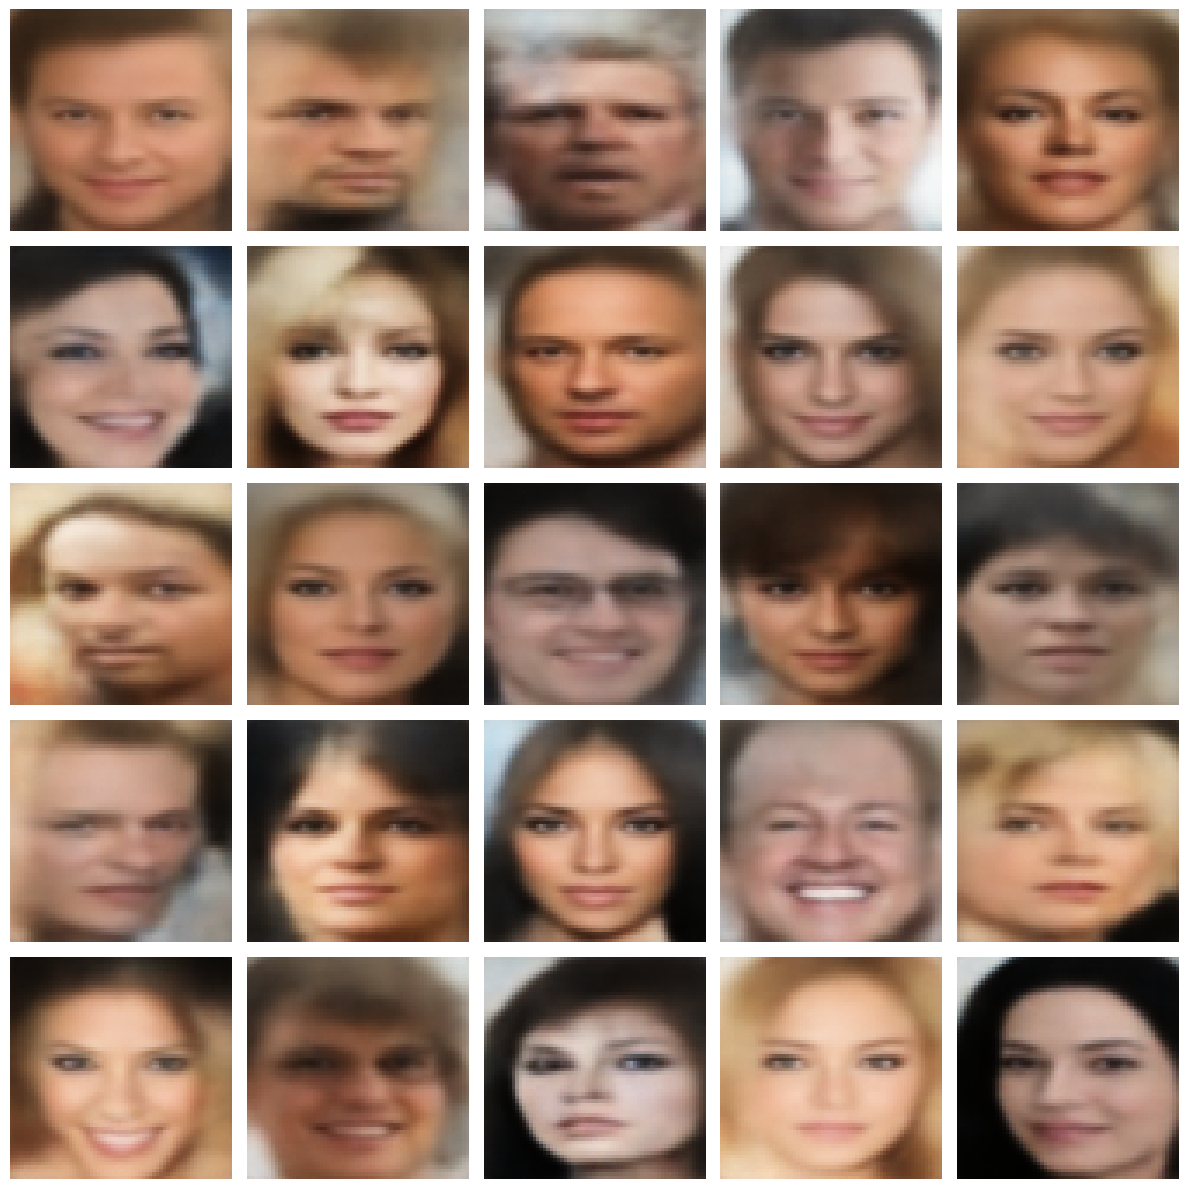

In [35]:
decoder.load_weights('E:/facial editing/archive/img_align_celeba/decoder_weights.weights.h5')
import matplotlib.pyplot as plt
import numpy as np

# Generate random latent vectors
latent_vector = tf.random.normal(shape=(25, latent_dim))

# Generate images
generated_images = decoder(latent_vector, training=False)

# Plot
fig, axes = plt.subplots(5, 5, figsize=(12, 12))
for i in range(5):
    for j in range(5):
        axes[i, j].imshow(generated_images[5 * i + j].numpy())
        axes[i, j].axis('off')
plt.tight_layout()
plt.show()


In [10]:
import imageio
import os
from natsort import natsorted
from IPython.display import Video

# Folder containing saved images
image_folder = 'archive/img_align_celeba/output'

# Output video path
video_path = 'archive/img_align_celeba/training_progress.mp4'

# Get sorted image files
image_files = natsorted([
    os.path.join(image_folder, fname)
    for fname in os.listdir(image_folder)
    if fname.endswith('.jpg')
])

# Create the video writer
writer = imageio.get_writer(video_path, fps=10)  # Adjust fps as needed

for filename in image_files:
    image = imageio.imread(filename)
    writer.append_data(image)

writer.close()

# Display the video inline (Jupyter)
Video(video_path)


C:\Users\Admin\AppData\Local\Temp\ipykernel_13064\2329320357.py:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1400, 1400) to (1408, 1408) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
